In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from keras import Model
%matplotlib inline

C:\Users\Hyunsil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. VBPR

## 1.1. Transfer Learning : VGG-16
- weights pre-trained on ImageNet
- default input size : 224x224
- channel_first, channel_last 모두 지원
- 주의사항 : input size설정시 이미지 크기는 channel보다 커야하고 32이하 이미지 사용 불가

In [2]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Flatten

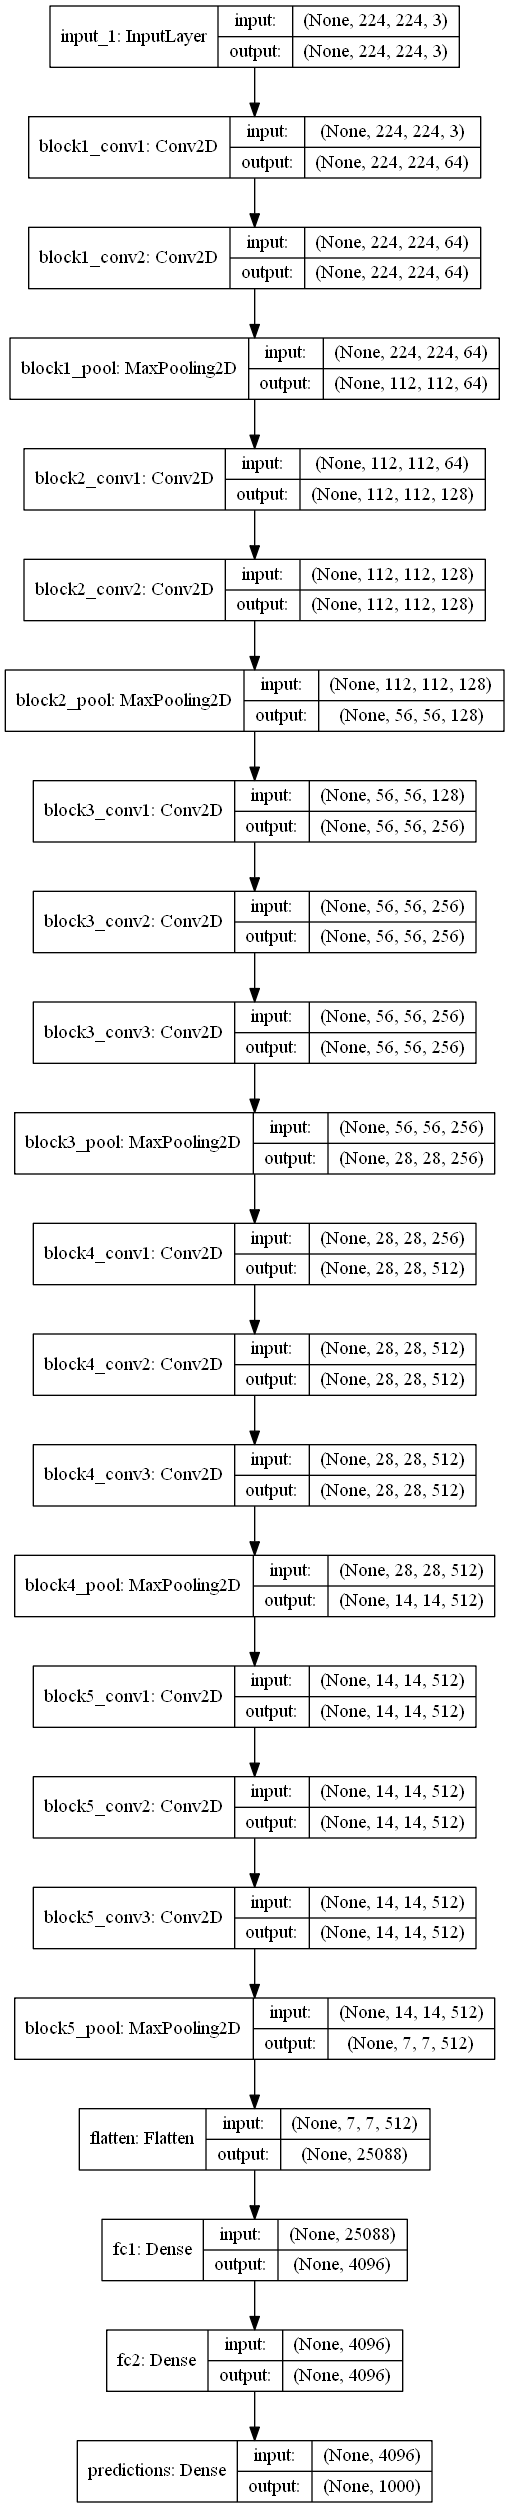

In [3]:
model = VGG16()
plot_model(model, show_shapes=True)
Image('model.png')

** Prameters **
- include_top=True : 3개의 dense층 포함 여부
- weights='imagenet' : None은 랜덤 초기값
- input_tensor=None : input layer를 사용하는 경우
- input_shape=None : include_top=False인 경우에 input shape를 지정
- pooling : include_top=False인 경우 None, 'avg', 'max' 중 선택
- classes : include_top=True이고 weights=None인 경우 출력층 지정

In [4]:
i_width, i_height, i_ch = 1024, 1024, 3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1024, 1024, 3)     0         
_________________________________________________________________
vgg16 (Model)                (None, 1000)              138357544 
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              4100096   
Total params: 142,457,640
Trainable params: 142,457,640
Non-trainable params: 0
_________________________________________________________________


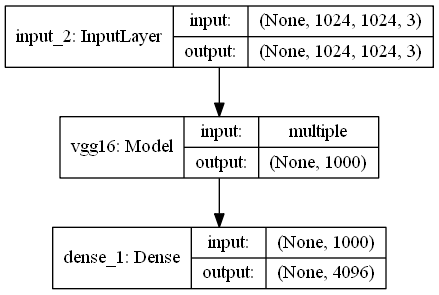

In [5]:
image_input = Input(shape=(i_width,i_height, i_ch))
vg = VGG16(include_top=True)(image_input)
out = Dense(4096, activation='relu')(vg)
model = Model(image_input, out)
model.summary()
plot_model(model, show_shapes=True)
Image('model.png')

## 1.2. Final Modeling

In [6]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Flatten, Embedding, dot, concatenate
latent_factors = 10
n_items = 100000
n_users = 100000

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image (InputLayer)              (None, 1024, 1024, 3 0                                            
__________________________________________________________________________________________________
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 1000)         138357544   Image[0][0]                      
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

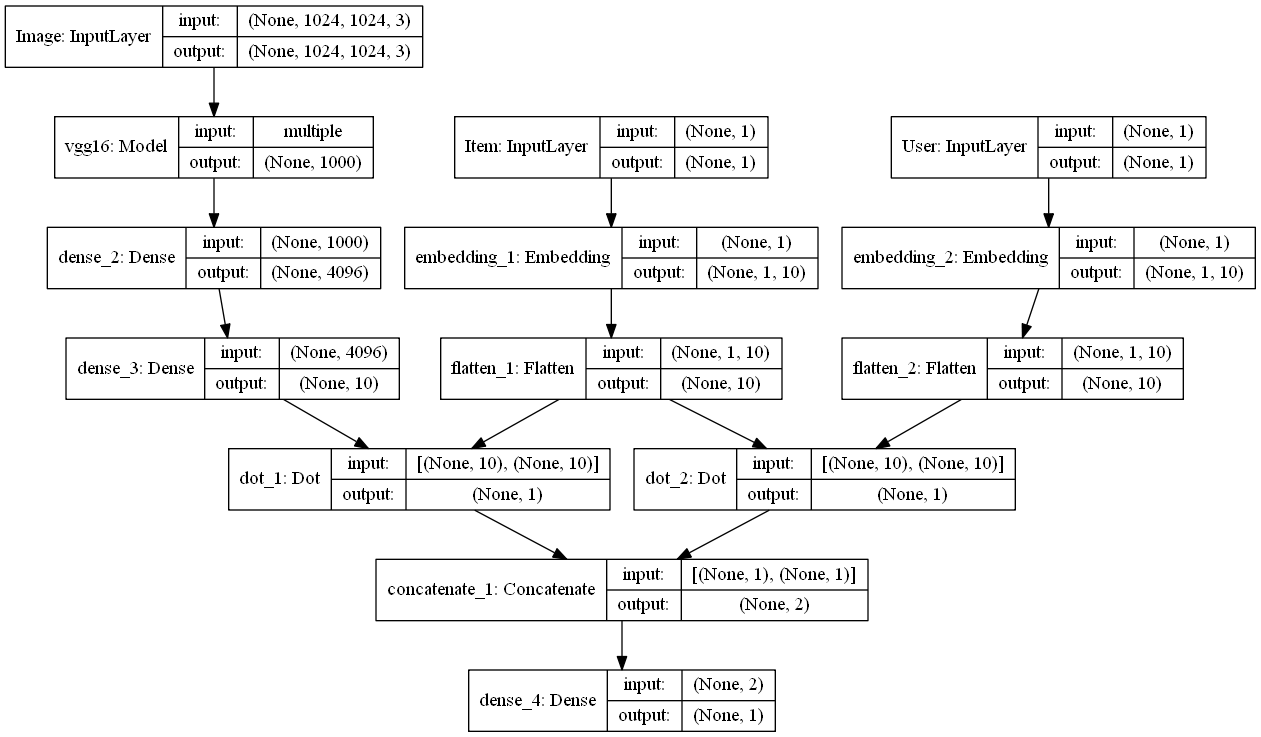

In [7]:
# cnn factors
image_input = Input(shape=(i_width,i_height, i_ch), name='Image')
vg = VGG16(include_top=True)(image_input)
vg_out = Dense(4096, activation='relu')(vg)
cnn_vec = Dense(latent_factors)(vg_out)

# item factors
item_input = Input(shape=[1],name='Item')
item_embed = Embedding(n_items + 1, latent_factors)(item_input)
item_vec = Flatten()(item_embed)

# user_factors
user_input = Input(shape=[1],name='User')
user_embed = Embedding(n_users + 1, latent_factors)(user_input)
user_vec = Flatten()(user_embed)

# merge
prod01 = dot([item_vec, cnn_vec], axes=1)
prod02 = dot([item_vec, user_vec], axes=1)
merge = concatenate([prod01, prod02])
out = Dense(1)(merge)
model = Model([image_input,item_input,user_input], out)
model.summary()
plot_model(model, show_shapes=True)
Image('model.png')

# Deep content-based music recommendation

In [8]:
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D

C:\Users\Hyunsil\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
  
C:\Users\Hyunsil\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
  after removing the cwd from sys.path.
C:\Users\Hyunsil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image (InputLayer)              (None, 599, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 599, 128, 256 7168        Image[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 149, 32, 256) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 149, 32, 256) 590080      max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

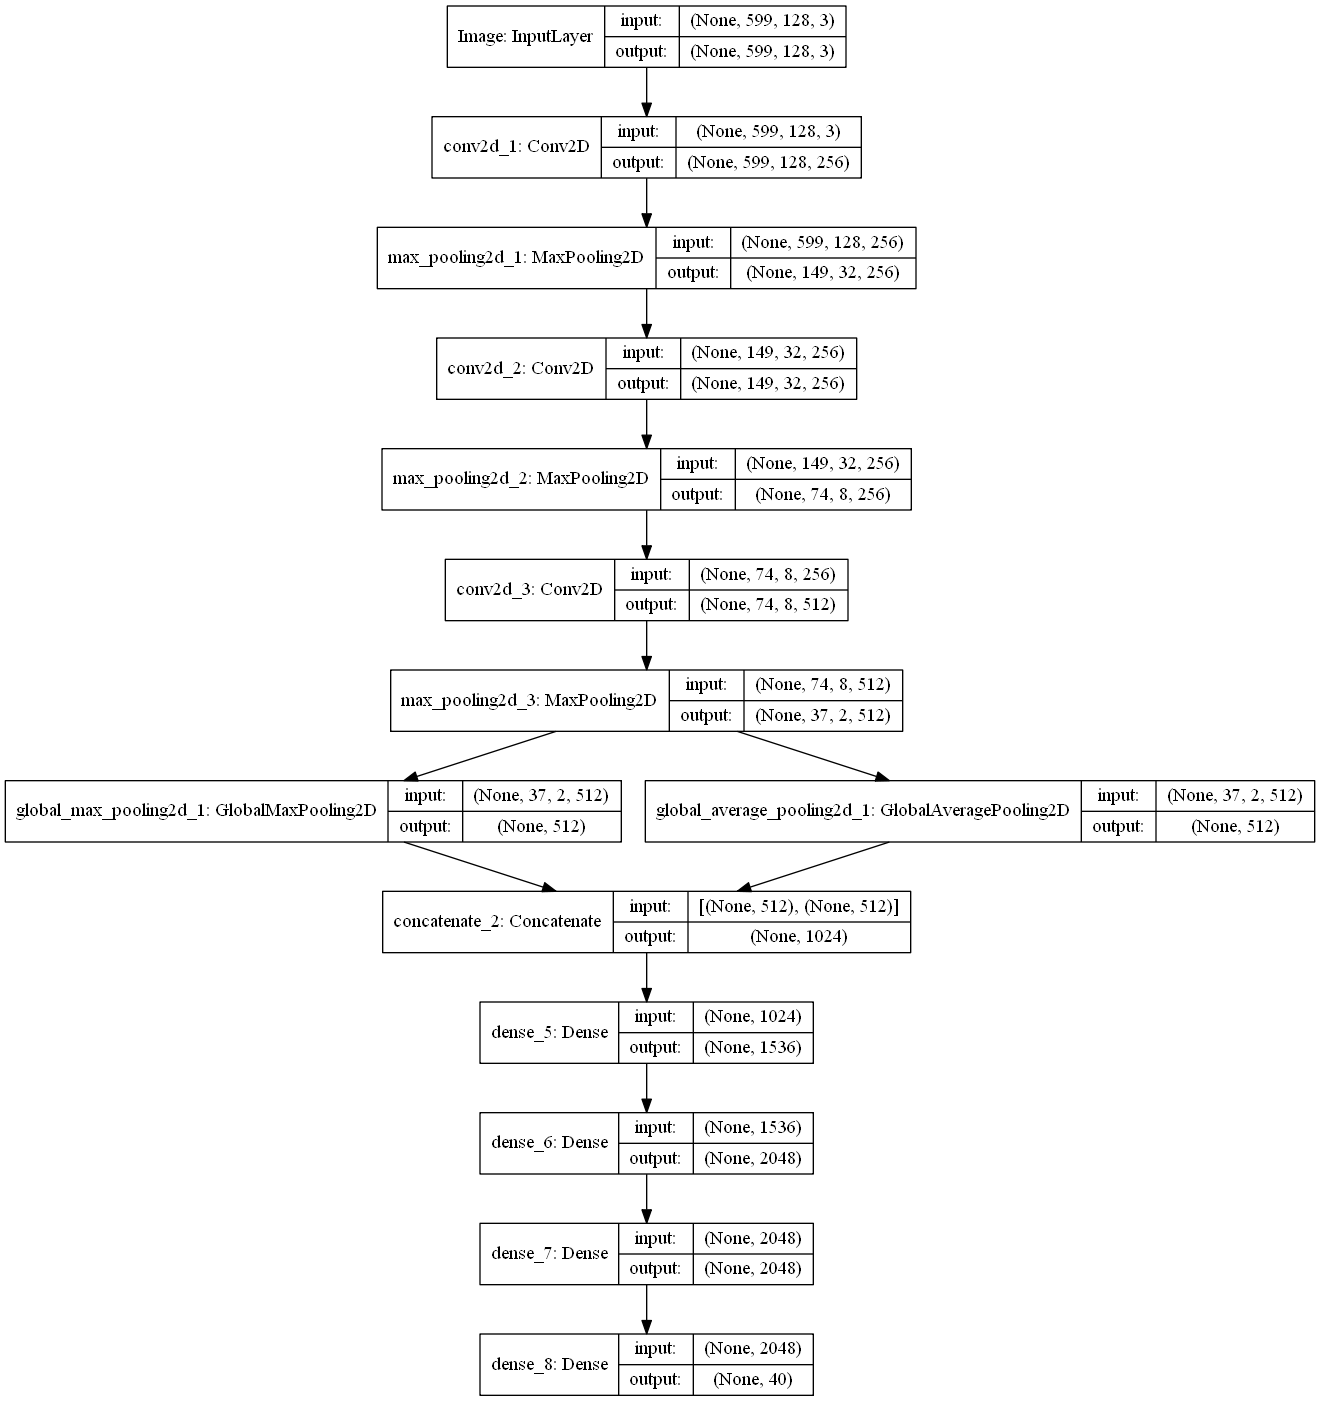

In [9]:
music_input = Input(shape=(599, 128, 3), name='Image')
conv1 = Conv2D(256, 3, 3, border_mode='same')(music_input)
pool1 = MaxPooling2D(pool_size=(4, 4))(conv1)
conv2 = Conv2D(256, 3, 3, border_mode='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 4))(conv2)
conv3 = Conv2D(512, 3, 3, border_mode='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 4))(conv3)

mean_pool = GlobalMaxPooling2D()(pool3)
max_pool = GlobalAveragePooling2D()(pool3)
merge = concatenate([mean_pool, max_pool])

d1 = Dense(1536)(merge)
d2 = Dense(2048)(d1)
d3 = Dense(2048)(d2)
out = Dense(40)(d3)
model = Model(music_input, out)
model.summary()
plot_model(model, show_shapes=True)
Image('model.png')